In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
from protest_impact.synthetic_region.hyperopt import get_data_part, grid_search

data = get_data_part(["top", "mid", "bottom"], 0.02)
data["size"].value_counts()

100.0      28
3.0        15
4.0        12
55000.0     3
53000.0     3
36000.0     3
25000.0     3
20500.0     3
20000.0     3
17000.0     3
11000.0     3
10500.0     3
Name: size, dtype: int64

In [5]:
normalizers = ["none", "mean", "standard", "robust", "power"]

search_spaces = [
    dict(
        normalize=normalizers,
        method=["mean"],
        training_interval=[28],
        prediction_interval=[28],
        agg_weekly=[True, False],
    ),
    dict(
        normalize=normalizers,
        method=["distance"],
        distance__inverse=[False, True],
        training_interval=[28],
        prediction_interval=[28],
        agg_weekly=[True, False],
    ),
    dict(
        normalize=normalizers,
        method=["sociodemographic"],
        sociodemographic__method=["corr", "ols", "pc", "pls", "nmf"],
        sociodemographic__sum_to_one=[True, False],
        training_interval=[28],
        prediction_interval=[28],
        agg_weekly=[True, False],
    ),
    dict(
        normalize=normalizers,
        method=["linear_regression", "ridge"],
        interpretable=[True, False],
        use_autoregressor=[False],
        training_interval=[28, 28 * 3, 28 * 12],
        prediction_interval=[28],
        agg_weekly=[True, False],
    ),
]

import optuna
from sklearn.exceptions import ConvergenceWarning

optuna.logging.disable_default_handler()

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

from protest_impact.synthetic_region.hyperopt import grid_search

study_names = grid_search(
    data, search_spaces, "eval-basic-tiny-v3", n_jobs=1, n_trials=300
)

  0%|          | 0/82 [00:00<?, ?it/s]

`GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distributed optimization or when re-running optimizations on already finished studies.
`GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distributed optimization or when re-running optimizations on already finished studies.
`GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distributed optimization or when re-running optimizations on already finished studies.
`GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distributed optimization or when re-running optimizations on already finished studies.
`GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distrib

ValueError: Input contains infinity or a value too large for dtype('float64').

In [3]:
import optuna

from protest_impact.util import project_root

storage = optuna.storages.RDBStorage(
    url="sqlite:///" + (project_root / "hyperopt" / "eval-basic-tiny-v3.db").as_posix()
)
# storage = optuna.storages.JournalStorage(
#     optuna.storages.JournalFileStorage(
#         (project_root / "hyperopt" / "eval-basic-tiny-v3.db").as_posix()
#     )
# )
studies = storage.get_all_studies()

In [22]:
import pandas as pd

best_trials = [storage.get_best_trial(s._study_id) for s in studies]
params = [dict(**t.params, **t.user_attrs) for t in best_trials]
df = pd.DataFrame(params)

In [5]:
df

,agg_weekly,interpretable,method,normalize,training_interval,use_autoregressor,Unnamed: 0,admin1,assoc_actor_1,co_terms,...,impact_2_days,impact_3_days,impact_7_days,relative_impact_14_days,relative_impact_1_days,relative_impact_21_days,relative_impact_28_days,relative_impact_2_days,relative_impact_3_days,relative_impact_7_days
0,True,False,linear_regression,standard,336,False,114,Berlin,FFF: Fridays for Future; Students (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,False,linear_regression,mean,336,False,580,Berlin,FFF: Fridays for Future; Students (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,ridge,none,336,False,1046,Berlin,FFF: Fridays for Future; Students (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,False,linear_regression,mean,336,False,119,Hamburg,FFF: Fridays for Future; Students (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,False,linear_regression,robust,336,False,585,Hamburg,FFF: Fridays for Future; Students (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,True,True,ridge,mean,336,False,1919,Bayern,Extinction Rebellion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,True,True,linear_regression,mean,336,False,1545,Berlin,ALG: Uprising of the Last Generation (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,True,False,ridge,mean,336,False,1659,Berlin,ALG: Uprising of the Last Generation (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,True,False,linear_regression,power,336,False,1654,Bayern,ALG: Uprising of the Last Generation (Germany),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df[["discourse_type", "size", "rrmse_mean", "relative_impact_1_weeks"]]

,discourse_type,size,rrmse_mean,relative_impact_1_weeks
0,climate,55000.0,0.170594,0.390763
1,climate_not_protest,55000.0,0.177204,0.491853
2,climate_and_protest,55000.0,0.252183,0.182895
3,climate,53000.0,0.158606,0.573142
4,climate_not_protest,53000.0,0.179861,1.106262
...,...,...,...,...
77,climate_not_protest,3.0,0.083956,0.123128
78,climate_not_protest,3.0,0.104455,0.015080
79,climate_and_protest,3.0,0.178260,-0.170847
80,climate_and_protest,3.0,0.327083,-0.083446


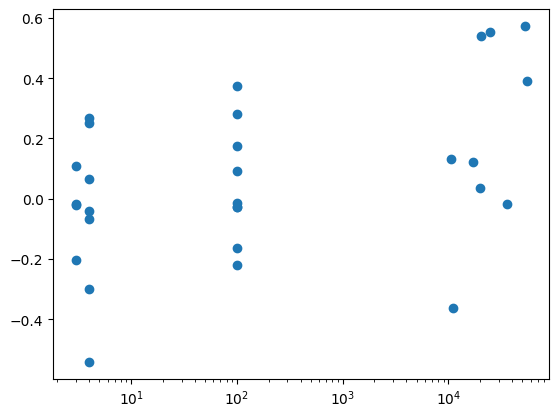

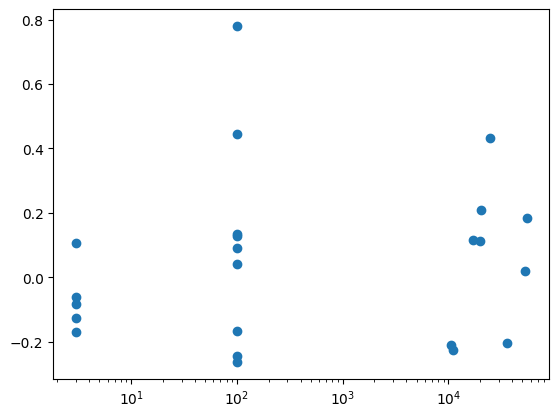

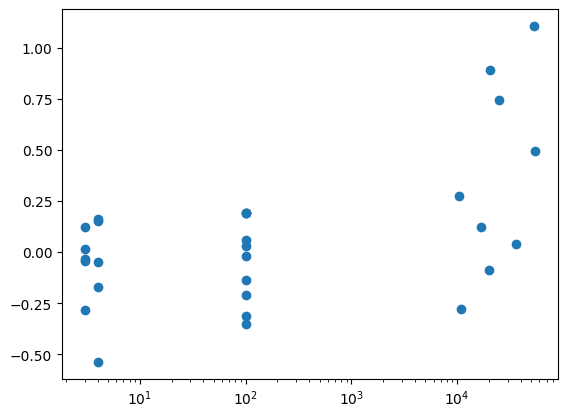

In [14]:
import matplotlib.pyplot as plt

df_ = df[df["discourse_type"] == "climate"]
plt.plot(df_["size"], df_["relative_impact_1_weeks"], "o")
plt.xscale("log")
plt.show()

df_ = df[df["discourse_type"] == "climate_and_protest"]
plt.plot(df_["size"], df_["relative_impact_1_weeks"], "o")
plt.xscale("log")
plt.show()

df_ = df[df["discourse_type"] == "climate_not_protest"]
plt.plot(df_["size"], df_["relative_impact_1_weeks"], "o")
plt.xscale("log")
plt.show()

<Axes: >

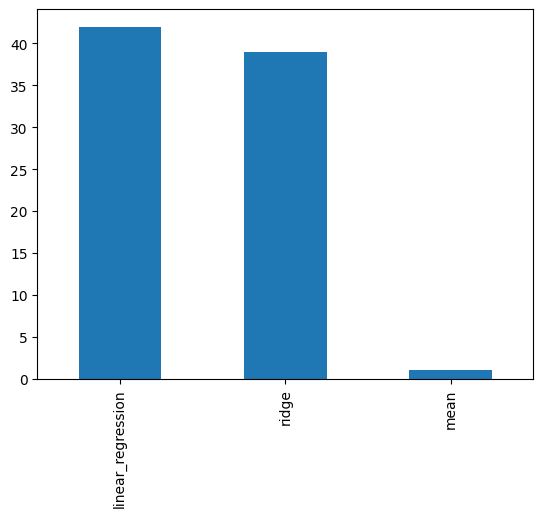

In [15]:
df["method"].value_counts().plot(kind="bar")

In [ ]:
df["sociodemographic__method"].value_counts().plot(kind="bar")

In [50]:
import json

dfs = []
for i in range(80):
    df0 = pd.DataFrame(
        json.loads(
            df[(df["agg_weekly"] == True) & df["discourse_type"] == "climate"][
                "comparison_df"
            ].iloc[i]
        )
    )
    df0["x"] = df0.index
    dfs.append(df0)
agg_df = pd.concat(dfs).groupby(["x"]).mean().reset_index()
agg_df.plot()

IndexError: single positional indexer is out-of-bounds

In [41]:
from tqdm.notebook import tqdm

trials = [storage.get_all_trials(s._study_id) for s in tqdm(studies)]

  0%|          | 0/82 [00:00<?, ?it/s]

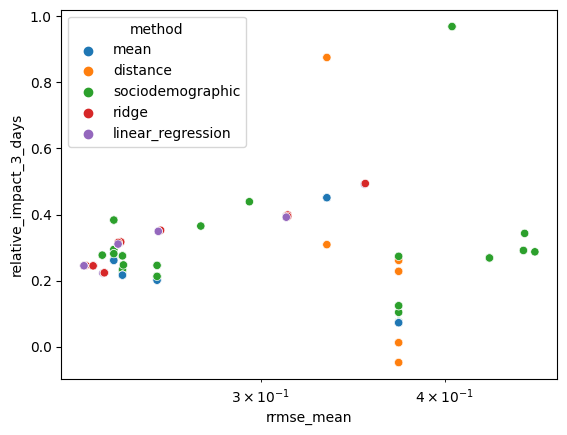

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
298,0.234282,sociodemographic,ols,False,standard,0.277181
83,0.234282,sociodemographic,ols,False,standard,0.277181
47,0.238544,sociodemographic,pls,True,robust,0.281605
333,0.238544,sociodemographic,corr,False,robust,0.263094
104,0.238544,sociodemographic,pc,True,robust,0.294306
97,0.238544,sociodemographic,corr,False,robust,0.263094
376,0.238544,sociodemographic,ols,True,robust,0.383311
420,0.238544,sociodemographic,pls,True,robust,0.281605
89,0.238544,sociodemographic,ols,True,robust,0.383311
441,0.238544,sociodemographic,corr,True,robust,0.263094


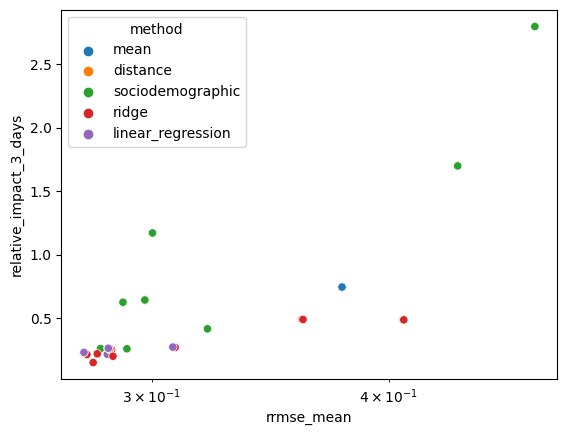

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
69,0.281818,sociodemographic,ols,False,standard,0.261268
426,0.289643,sociodemographic,nmf,True,standard,0.625475
40,0.289643,sociodemographic,ols,True,standard,0.625475
81,0.289643,sociodemographic,corr,True,standard,0.625475
65,0.289643,sociodemographic,pc,True,standard,0.625475
91,0.289643,sociodemographic,pls,True,standard,0.625475
70,0.289643,sociodemographic,corr,False,standard,0.625475
112,0.289643,sociodemographic,nmf,True,standard,0.625475
96,0.291032,sociodemographic,ols,False,power,0.259836
388,0.291032,sociodemographic,ols,False,power,0.259836


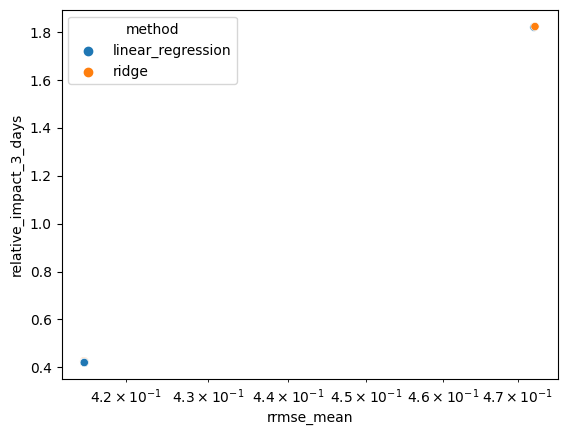

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days


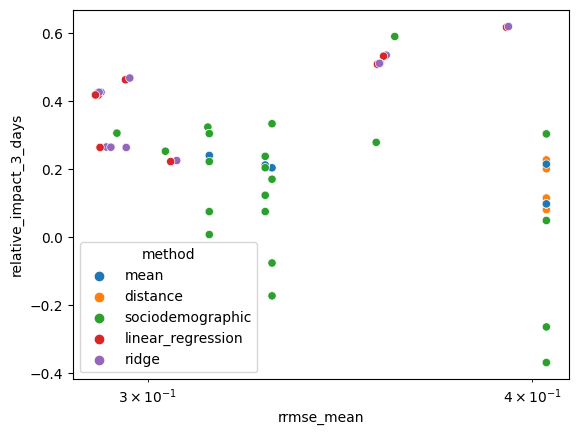

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
344,0.293117,sociodemographic,ols,False,standard,0.306051
85,0.293117,sociodemographic,ols,False,standard,0.306051
430,0.303953,sociodemographic,ols,False,power,0.252876
146,0.303953,sociodemographic,ols,False,power,0.252876
53,0.313761,sociodemographic,ols,False,robust,0.323846
426,0.314105,sociodemographic,nmf,True,standard,0.304828
139,0.314105,sociodemographic,pc,True,standard,0.008110
155,0.314105,sociodemographic,pls,True,standard,0.075507
316,0.314105,sociodemographic,nmf,True,standard,0.304828
421,0.314105,sociodemographic,corr,False,standard,0.222731


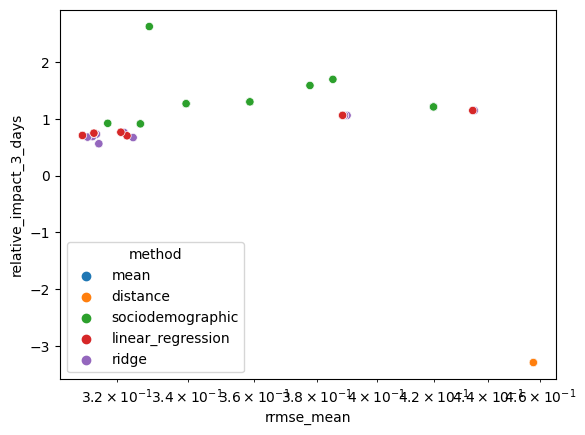

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
87,0.317457,sociodemographic,ols,False,standard,0.920577
86,0.326486,sociodemographic,ols,False,power,0.911381
361,0.326486,sociodemographic,ols,False,power,0.911381
121,0.328997,sociodemographic,ols,False,robust,2.624256
349,0.339560,sociodemographic,nmf,True,standard,1.267080
360,0.339560,sociodemographic,pls,True,standard,1.267080
358,0.339560,sociodemographic,pc,True,standard,1.267080
68,0.339560,sociodemographic,corr,True,standard,1.267080
141,0.339560,sociodemographic,ols,True,standard,1.267080
81,0.339560,sociodemographic,corr,False,standard,1.267080


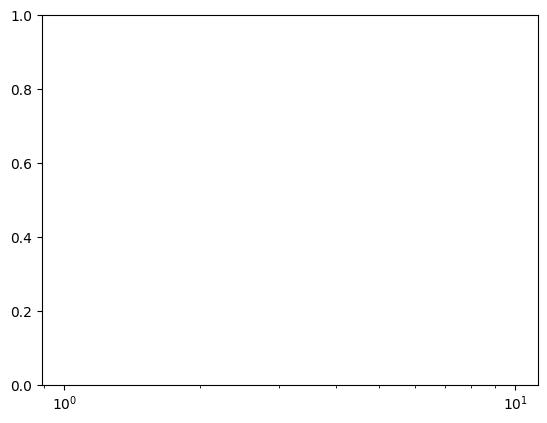

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days


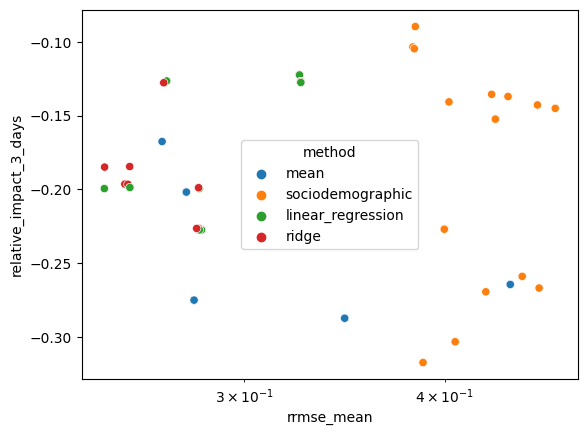

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
32,0.382197,sociodemographic,pls,False,robust,-0.103418
72,0.382992,sociodemographic,pls,False,power,-0.104609
76,0.383562,sociodemographic,pls,False,standard,-0.089562
63,0.387835,sociodemographic,corr,False,robust,-0.317332
127,0.387835,sociodemographic,corr,True,robust,-0.317332
118,0.387835,sociodemographic,corr,True,robust,-0.317332
304,0.399857,sociodemographic,corr,False,power,-0.226943
36,0.399857,sociodemographic,corr,True,power,-0.226943
277,0.399857,sociodemographic,corr,False,power,-0.226943
85,0.399857,sociodemographic,corr,False,power,-0.226943


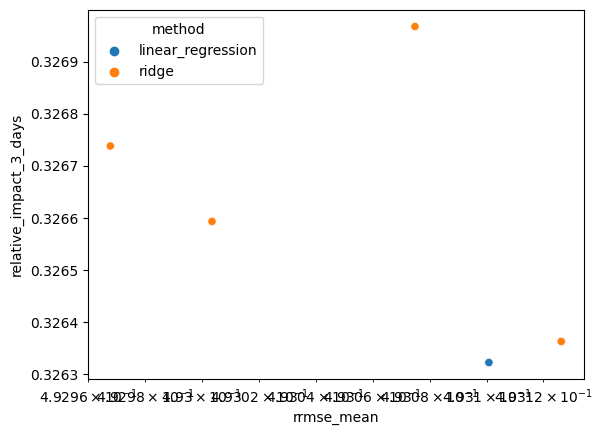

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days


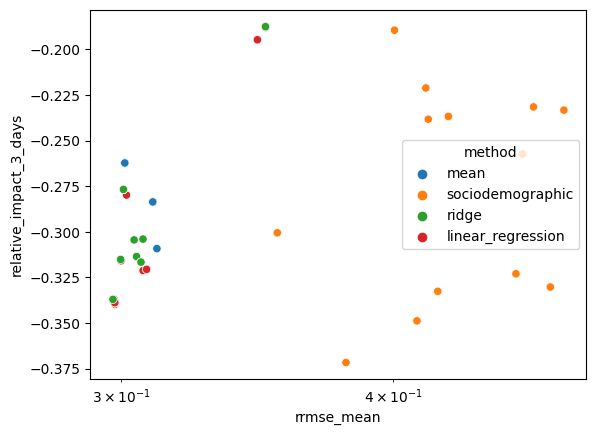

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
23,0.353829,sociodemographic,corr,False,robust,-0.300543
41,0.353829,sociodemographic,corr,True,robust,-0.300543
27,0.380484,sociodemographic,corr,True,power,-0.371652
98,0.380484,sociodemographic,corr,False,power,-0.371652
308,0.380484,sociodemographic,corr,True,power,-0.371652
61,0.400499,sociodemographic,pls,False,robust,-0.189538
22,0.410127,sociodemographic,corr,False,standard,-0.348801
90,0.410127,sociodemographic,corr,True,standard,-0.348801
39,0.413973,sociodemographic,pls,False,power,-0.221198
24,0.415048,sociodemographic,pls,False,standard,-0.238331


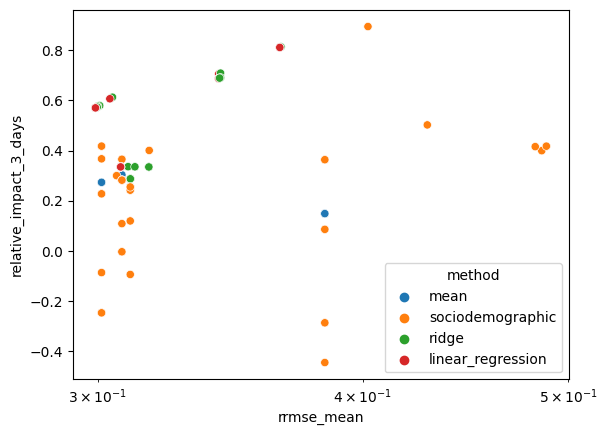

,rrmse_mean,method,sociodemographic__method,sociodemographic__sum_to_one,normalize,relative_impact_3_days
35,0.301306,sociodemographic,ols,False,standard,0.367097
24,0.301307,sociodemographic,corr,True,robust,0.227584
100,0.301307,sociodemographic,pls,True,robust,-0.086652
32,0.301307,sociodemographic,pc,True,robust,-0.247206
93,0.301307,sociodemographic,nmf,True,robust,0.417787
34,0.301307,sociodemographic,corr,False,robust,0.227584
69,0.301307,sociodemographic,ols,True,robust,0.417787
305,0.301307,sociodemographic,pc,True,robust,-0.247206
48,0.306274,sociodemographic,ols,False,power,0.299985
21,0.308028,sociodemographic,corr,False,standard,0.282016


In [19]:
import seaborn as sns

for trial in trials[:10]:
    df = pd.DataFrame([dict(**t.params, **t.user_attrs) for t in trial])
    df = df[df["rrmse_mean"] < 0.5]
    df = df[df["relative_impact_3_days"].abs() < 5]
    sns.scatterplot(data=df, x="rrmse_mean", y="relative_impact_3_days", hue="method")
    plt.xscale("log")
    plt.show()
    display(
        df[df["method"] == "sociodemographic"].sort_values("rrmse_mean")[
            [
                "rrmse_mean",
                "method",
                "sociodemographic__method",
                "sociodemographic__sum_to_one",
                "normalize",
                "relative_impact_3_days",
            ]
        ]
    )

TODO: time-series plots